# 10 - Data Assimilation

## Using PAVICS-Hydro to perform data assimilation of streamflow to prepare the model states for a forecast.

Here we apply the Ensemble Kalman Filter (EnKF) data assimilation method to the initial states of a `Raven` hydrological model, which will allow improving the estimation of the initial states to reduce the initial model bias. This also helps improve the forecast skill for shorter-term forecasts (up to a few days lead-time), and in some instances, can also improve longer-term forecasts. 

In [1]:
import datetime as dt
import xarray as xr
import numpy as np
import xskillscore as xss
import matplotlib.pyplot as plt

from ravenpy.utilities.testdata import get_file
from ravenpy.utilities.data_assimilation import perturb_full_series, sequential_assimilation, assimilation_initialization

## A note on datasets

For this introduction to data assimilation, we will use pre-existing datasets that are hosted on the PAVICS-Hydro servers, as we did in the previous example notebooks. We also provide a model configuration and parameterization to keep things simple. However, you can adapt this to your own data and model setups using the tools seen in the previous notebooks.

In [2]:
# Here we are using a pre-defined file that is available on PAVICS-Hydro servers. 
# Replace with your own file that you can upload to your writable-workspace if desired.
forcing = get_file("raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc")

# Display the datasets that we will be using
display(forcing)

PosixPath('/home/david/.raven_testing_data/master/raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc')

## Case 1: Open-loop simulation

An *open-loop* simulation is one that is done without any data assimilation at any time step. To demonstrate the ability of the data assimilation method to improve the model states and reduce initial biases, we will compare an open-loop simulation to a simulation that has integrated data assimilation.



In [3]:
# Define some of the common parameters for each model run
common_model_inputs=dict(
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    params=(0.1353389, -0.005067198, 576.8007, 6.986121, 1.102917, 0.9224778)
)


In [4]:
# Import the GR4JCN model template we will be using 
from ravenpy.models import GR4JCN

# Generate a GR4JCN-configured Raven model instance. 
# By replacing "GR4JCN()" by "HMETS()", we would then be running a HMETS model emulator instead. 
model = GR4JCN()

# Here is where we launch the model using the configuration parameters, as well as the forcing data and start and end dates. 
model(
    ts=forcing,
    start_date=dt.datetime(1997, 1, 1),
    end_date=dt.datetime(1999, 1, 1),
    **common_model_inputs,
)

# Note that the warnings below are informative, and do not mean something went wrong.

/home/david/.conda/envs/ravenwps-env/lib/python3.9/site-packages/ravenpy/models/base.py:434: RavenWarning: Initial conditions specified for state variable not in model (DEPRESSION)
  warn(msg, category=RavenWarning)
/home/david/.conda/envs/ravenwps-env/lib/python3.9/site-packages/ravenpy/models/base.py:434: RavenWarning: Gauge:Initialize: both snowfall and rainfall data are provided at a gauge, but :RainSnowFraction method is something other than RAINSNOW_DATA. Snow fraction will be recalculated.
  warn(msg, category=RavenWarning)
/home/david/.conda/envs/ravenwps-env/lib/python3.9/site-packages/ravenpy/models/base.py:434: RavenWarning: PET data supplied at gauge Gauge1 but will not be used due to choice of forcing generation algorithm
  warn(msg, category=RavenWarning)
/home/david/.conda/envs/ravenwps-env/lib/python3.9/site-packages/ravenpy/models/base.py:434: RavenWarning: CModelInitialize: if a non-standard calendar is used, all observation data must be converted into the same calend

In [5]:
openloop_hydrograph = model.hydrograph.q_sim

## Case 2: Simulation with EnKF data assimilation 

Run the same model, but perform the data assimilation every 7 days during the entire period. The process is a bit more involved, but we will attempt to keep things as simple as possible here.

The next cell defines the experimental conditions for the assimilation: 
- the state variables to be assimilated,
- the distribution and shape of random perturbations, 
- number of members, 
- the assimilation period and frequency. 

In [6]:
# First, define which variables we want to assimilate. 
# Here we only adjust the water content of the 2 first layers of soil (soil0 and soil1)
assim_var = ("soil0", "soil1")

# Next, define a set of hyperparameters to use during the assimilation steps.
# This includes both the distribution and a parameter controlling spread.
# The default distribution is the normal distribution, so we only need to specify distributions other than normal. 
dists = {
    "pr": "gamma",
    "rainfall": "gamma",
    "prsn": "gamma",
    "water_volume_transport_in_river_channel": "rnorm",
}


# Hyperparameters for the input uncertainty. 
# The `std` values represent the uncertainty around the observed values; larger values imply more uncertainty.
# "water_volume_transport_in_river_channel" refers to the observed discharge, and must absolutely be 
# specified for assimilation. 
std={
    "rainfall": 0.30,
    "prsn": 0.30,
    "tasmin": 2.0,
    "tasmax": 2.0,
    "water_volume_transport_in_river_channel": 0.10 
}

# Hyperparameters on the number of ensemble members to use for EnKF.
# Typically 25 is a good number, but here we will use 5 to speed things up. 
n_members = 5

# Assimilation period (days between each assimilation step).
assim_step_days = 7

# Start and end dates of the assimilation period
start_date = dt.datetime(1997,1,1)
end_date = dt.datetime(1999,1,1)


### Run the sequential assimilation

We first start by initializing a new GR4JCN model instance, and initialize the state variables so we can get an ensemble of initial states to pass to the assimilation functions.

In [7]:
# Let's re-initialize a new model instance of GR4JCN for the assimilation part:
model = GR4JCN()

# Do the first assimilation pass to get hru_states and basin_states.
# Can be skipped if there is already this data from a previous run.
# This will return the model instance with `n_members` identical initial 
# states at the end of the first period of `assim_step_days`.
model, xa, hru_states, basin_states = assimilation_initialization(
    model,
    ts=forcing,
    start_date=start_date,
    end_date=start_date + dt.timedelta(days=assim_step_days - 1),
    assim_var=assim_var,
    n_members=n_members,
    **common_model_inputs,
)

/home/david/.conda/envs/ravenwps-env/lib/python3.9/site-packages/ravenpy/models/base.py:434: RavenWarning: Initial conditions specified for state variable not in model (DEPRESSION)
  warn(msg, category=RavenWarning)
/home/david/.conda/envs/ravenwps-env/lib/python3.9/site-packages/ravenpy/models/base.py:434: RavenWarning: Gauge:Initialize: both snowfall and rainfall data are provided at a gauge, but :RainSnowFraction method is something other than RAINSNOW_DATA. Snow fraction will be recalculated.
  warn(msg, category=RavenWarning)
/home/david/.conda/envs/ravenwps-env/lib/python3.9/site-packages/ravenpy/models/base.py:434: RavenWarning: PET data supplied at gauge Gauge1 but will not be used due to choice of forcing generation algorithm
  warn(msg, category=RavenWarning)
/home/david/.conda/envs/ravenwps-env/lib/python3.9/site-packages/ravenpy/models/base.py:434: RavenWarning: CModelInitialize: if a non-standard calendar is used, all observation data must be converted into the same calend

In [8]:
# Now we can create a perturbed inputs datasets to be used for the rest of the assimilation.
perturbed = perturb_full_series(
    model,
    std=std,
    start_date=start_date,
    end_date=end_date,
    dists=dists,
    n_members=n_members,
)

# Write perturbed dataset to disk.
p_fn = model.workdir / "perturbed_forcing.nc"
perturbed = xr.Dataset(perturbed)
perturbed.to_netcdf(p_fn, mode="w")

# A last step: Get observed streamflow required in the assimilation and to plot results later.
q_obs = xr.open_dataset(forcing)["qobs"].sel(time=slice(start_date, end_date))

In [9]:
%%capture --no-display 
# Adding this to avoid spamming warning messages for overwriting files.

# At this point, we have: 
# 1. an ensemble of initial states after the first assim_step_days (`assimilation_initialization`), and 
# 2. perturbed hydrometeorological data for the assimilation and simulation steps (`perturb_full_series`). 

# We can now perform the assimilation loop and produce streamflows for the entire series:
q_assim, hru_states, basin_states = sequential_assimilation(
    model,
    hru_states,
    basin_states,
    p_fn,
    q_obs,
    assim_var,
    # We have already done one period during initialization:
    start_date=start_date + dt.timedelta(days=assim_step_days), 
    end_date=end_date,
    n_members=n_members,
    assim_step_days=assim_step_days,
)

# Also note that `hru_states` and `basin_states` can be used to generate a forecast for the next time step.

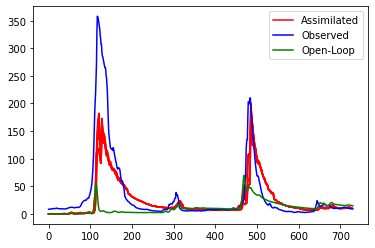

RMSE - Assimilated: 41.55342771561716
RMSE - Open-Loop: 66.72114486210643


In [10]:
# We can now plot everything!
plt.plot(q_assim.T, "r", label=None)  # plot the assimilated flows
plt.plot(q_assim[0,:].T, "r", label="Assimilated")  # plot the assimilated flows
plt.plot(q_obs.T, "b", label="Observed")  # plot the observed flows
plt.plot(openloop_hydrograph, "g", label="Open-Loop") # plot the open_loop (simulation with no assimilation)
plt.legend()
plt.show()

print('RMSE - Assimilated: ' + str(xss.rmse(q_assim.mean(dim='state').T,q_obs[0:q_assim.shape[1]].T).data))
print('RMSE - Open-Loop: ' + str(xss.rmse(openloop_hydrograph[0:q_assim.shape[1],0],q_obs[0:q_assim.shape[1]].T).data))

In [79]:
# In the figure, click on the legend handles to partially hide lines
import hvplot.xarray
import holoviews as hv

ga = [q_assim.sel(state=s).hvplot(color="r", label=f"Assimilated: {s}") for s in q_assim.state.values]
go = q_obs.hvplot(color="b", label="Observed")
gol = openloop_hydrograph.squeeze().hvplot(color="g", label="Open-loop", title="Assimilation")
fig = hv.Overlay(ga + [go, gol])
display(fig)
print('RMSE - Assimilated: ' + str(xss.rmse(q_assim.mean(dim='state').T,q_obs[0:q_assim.shape[1]].T).data))
print('RMSE - Open-Loop: ' + str(xss.rmse(openloop_hydrograph[0:q_assim.shape[1],0],q_obs[0:q_assim.shape[1]].T).data))


:Overlay
   .Curve.Assimilated_colon_0    :Curve   [time]   (q_sim)
   .Curve.Assimilated_colon_1    :Curve   [time]   (q_sim)
   .Curve.Assimilated_colon_2    :Curve   [time]   (q_sim)
   .Curve.Assimilated_colon_3    :Curve   [time]   (q_sim)
   .Curve.Assimilated_colon_4    :Curve   [time]   (q_sim)
   .Curve.Observed               :Curve   [time]   (qobs)
   .Curve.Open_hyphen_minus_loop :Curve   [time]   (q_sim)

RMSE - Assimilated: 41.55342771561716
RMSE - Open-Loop: 66.72114486210643
